In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from scipy.stats import norm
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import yfinance as yf
import pandas as pd
import datetime

def get_data_from_yahoo(tickers):
    """
    From Yahoo Finance download Equity and Option data
    tickers (list): ['TSLA', 'SPY', '^VIX']
    """
    all_equity_data = pd.DataFrame()
    all_options_data = pd.DataFrame()
    
    today = datetime.date.today()
    print(f"Download date: {today}")
    print("-" * 30)

    for symbol in tickers:
        
        ticker = yf.Ticker(symbol)

        # Download Equity Data
        # Using Spot
        # Remember download data between 9:30-16:00
        try:
            # regularMarketPrice
            current_price = ticker.info.get('currentMarketPrice') or ticker.info.get('regularMarketPrice') or ticker.history(period='1d')['Close'].iloc[-1]
        except:
            # If fail, use the last price
            current_price = ticker.history(period='1d')['Close'].iloc[-1]
            
        equity_row = pd.DataFrame({
            'Symbol': [symbol],
            'Date': [today],
            'Price': [current_price],
            'Source': ['Yahoo Finance']
        })
        all_equity_data = pd.concat([all_equity_data, equity_row], ignore_index=True)
        
        # Dowanload Option Data

        expirations = ticker.options
        
        # Next three month 'the third Friday'
        
        valid_dates = []
        for date_str in expirations:
            exp_date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
            
            # Calsulate how many month from now to expire day
            months_diff = (exp_date.year - today.year) * 12 + (exp_date.month - today.month)
            
            if 0 <= months_diff <= 3:
                # Find 'the third Friday'
                # Method：is friday? (weekday==4) and num between 15-21
                # ^VIX is Wednesday
                if exp_date.weekday() == 4 and 15 <= exp_date.day <= 21:
                    valid_dates.append(date_str)
        

        # Download Call and Put fit the requirement
        for exp in valid_dates:
            opt = ticker.option_chain(exp)
            
            # Calls
            calls = opt.calls
            calls['Type'] = 'Call'
            calls['Expiration'] = exp
            
            # Puts
            puts = opt.puts
            puts['Type'] = 'Put'
            puts['Expiration'] = exp
            
            # Combine
            combined = pd.concat([calls, puts])
            combined['Underlying_Symbol'] = symbol
            combined['Download_Date'] = today
            combined['Underlying_Price_Snapshot'] = current_price 
            
            all_options_data = pd.concat([all_options_data, combined], ignore_index=True)

    # Cleaning the data

    # remove duplicates
    all_options_data.drop_duplicates(inplace=True)
    all_equity_data.drop_duplicates(inplace=True)
    
    all_options_data.reset_index(drop=True, inplace=True)
    all_equity_data.reset_index(drop=True, inplace=True)

    return all_equity_data, all_options_data


tickers = ['TSLA', 'SPY', '^VIX']
equity_df, options_df = get_data_from_yahoo(tickers)


print("\n=== Equity Data Preview ===")
print(equity_df)
print("\n=== Options Data Preview ===")
print(options_df[['Underlying_Symbol', 'Expiration', 'Type', 'strike', 'lastPrice', 'impliedVolatility']].head())

# Save as Data1 and Data2
# options_df.to_csv("DATA1_option.csv", index=False)
# equity_df.to_csv("DATA1_equity.csv", index=False)

Download date: 2026-02-14
------------------------------

=== Equity Data Preview ===
  Symbol        Date   Price         Source
0   TSLA  2026-02-14  417.44  Yahoo Finance
1    SPY  2026-02-14  681.75  Yahoo Finance
2   ^VIX  2026-02-14   20.60  Yahoo Finance

=== Options Data Preview ===
  Underlying_Symbol  Expiration  Type  strike  lastPrice  impliedVolatility
0              TSLA  2026-02-20  Call   100.0     315.58           4.210942
1              TSLA  2026-02-20  Call   110.0     321.40          10.186039
2              TSLA  2026-02-20  Call   120.0     319.63           3.609376
3              TSLA  2026-02-20  Call   130.0     309.87           3.386720
4              TSLA  2026-02-20  Call   140.0     299.78           3.250002


In [3]:
options_df = pd.read_csv('DATA1_option.csv')
equity_df = pd.read_csv('DATA1_equity.csv')

In [4]:
print(options_df[['Underlying_Symbol', 'Expiration', 'Type', 'strike', 'lastPrice', 'impliedVolatility']].head())
print('-'*30)
print(equity_df)

  Underlying_Symbol  Expiration  Type  strike  lastPrice  impliedVolatility
0              TSLA  2026-02-20  Call   100.0     315.58           4.507817
1              TSLA  2026-02-20  Call   110.0     321.40           8.879399
2              TSLA  2026-02-20  Call   120.0     319.63           3.913086
3              TSLA  2026-02-20  Call   130.0     309.87           3.253908
4              TSLA  2026-02-20  Call   140.0     299.78           3.021487
------------------------------
  Symbol        Date   Price         Source
0   TSLA  2026-02-12  417.07  Yahoo Finance
1    SPY  2026-02-12  681.27  Yahoo Finance
2   ^VIX  2026-02-12   20.82  Yahoo Finance


In [5]:
df = options_df.copy() 
# Risk-Free Rate
current_rate_percent = 3.64 
risk_free_rate = current_rate_percent / 100
df['Risk_Free_Rate'] = risk_free_rate

# Time to Maturity
# Make sure datetime format
df['Expiration'] = pd.to_datetime(df['Expiration'])
df['Download_Date'] = pd.to_datetime(df['Download_Date'])

# Diff of Days
# .dt.days
df['Days_to_Maturity'] = (df['Expiration'] - df['Download_Date']).dt.days

# Yearly basis
df['Time_to_Maturity'] = df['Days_to_Maturity'] / 365

cols_to_show = ['Underlying_Symbol', 'Expiration', 'Download_Date', 
                'Underlying_Price_Snapshot', 'Risk_Free_Rate', 'Time_to_Maturity']

print(df[cols_to_show].head())

  Underlying_Symbol Expiration       Download_Date  Underlying_Price_Snapshot  \
0              TSLA 2026-02-20 2026-02-12 20:52:55                 417.070007   
1              TSLA 2026-02-20 2026-02-12 20:52:55                 417.070007   
2              TSLA 2026-02-20 2026-02-12 20:52:55                 417.070007   
3              TSLA 2026-02-20 2026-02-12 20:52:55                 417.070007   
4              TSLA 2026-02-20 2026-02-12 20:52:55                 417.070007   

   Risk_Free_Rate  Time_to_Maturity  
0          0.0364          0.019178  
1          0.0364          0.019178  
2          0.0364          0.019178  
3          0.0364          0.019178  
4          0.0364          0.019178  


Part2

In [6]:
def black_scholes_price(S, K, T, r, sigma, option_type='Call'):
    if T <= 0 or sigma <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'Call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

In [7]:
def bisection_iv_solver(target_price, S, K, T, r, option_type, tol=1e-6, max_iter=100):

    # Lower bond
    low = 0.0001
    # Upper bond
    high = 5.0    
    
    # Check Boundary：If price < Intrinsic Value, IV not exist(NAN)
    intrinsic_val = max(0, S - K) if option_type == 'Call' else max(0, K - S)
    if target_price < intrinsic_val:
        return np.nan

    for _ in range(max_iter):
        # midpoint = (low + high) / 2.
        mid = (low + high) / 2
        # Calaulate theoretical option price
        price_mid = black_scholes_price(S, K, T, r, mid, option_type)
        diff = price_mid - target_price
        
        if abs(diff) < tol:
            return mid
        
        if diff > 0:
            # Price too high -> reduce vi
            high = mid 
        else:
            # Price too low -> increase vi
            low = mid   
            
    return (low + high) / 2 

In [8]:
df_calc = df.copy()

# Requirement: Volume is nonzero
df_calc = df_calc[df_calc['volume'] > 0].copy()

# Requirement: Bid and Ask exist
df_calc = df_calc[(df_calc['bid'] > 0) & (df_calc['ask'] > 0)].copy()

# Requirement: Use average of Bid and Ask as option value
df_calc['Market_Price'] = (df_calc['bid'] + df_calc['ask']) / 2

targets = ['TSLA', 'SPY']

print(f"{'Symbol':<6} | {'Target':<15} | {'Strike':<8} | {'Type':<4} | {'Calculated IV':<15}")
print("-" * 65)

for symbol in targets:
    subset = df_calc[df_calc['Underlying_Symbol'] == symbol].copy()
    
    if subset.empty:
        print(f"{symbol} No answer (maybe Volume=0 or Bid/Ask nan)")
        continue

    # Spot price: S
    S0 = subset['Underlying_Price_Snapshot'].iloc[0]
    
    # Report IV at the money (Closest Strike)
    # Find Strike which has the smallest distance with S0 
    subset['dist_to_atm'] = abs(subset['strike'] - S0)
    closest_row = subset.loc[subset['dist_to_atm'].idxmin()]
    
    # Calculate ATM Oprion's IV
    iv_atm_specific = bisection_iv_solver(
        target_price=closest_row['Market_Price'],
        S=S0,
        K=closest_row['strike'],
        T=closest_row['Time_to_Maturity'],
        r=closest_row['Risk_Free_Rate'],
        option_type=closest_row['Type']
    )
    
    print(f"{symbol:<6} | {'Closest ATM':<15} | {closest_row['strike']:<8} | {closest_row['Type']:<4} | {iv_atm_specific:.6f}")

    # Average IV for options "between ITM and OTM"
    # Def: Moneyness = S0 / K
    # Range: 0.9 <= S0 / K <= 1.1
    
    subset['Moneyness'] = S0 / subset['strike']
    mask_atm_range = (subset['Moneyness'] >= 0.9) & (subset['Moneyness'] <= 1.1)
    atm_group = subset[mask_atm_range].copy()
    calculated_ivs = []

    for index, row in atm_group.iterrows():
        iv = bisection_iv_solver(
            target_price=row['Market_Price'],
            S=S0,
            K=row['strike'],
            T=row['Time_to_Maturity'],
            r=row['Risk_Free_Rate'],
            option_type=row['Type']
        )
        if not np.isnan(iv):
            calculated_ivs.append(iv)
    
    # Ave
    if len(calculated_ivs) > 0:
        avg_iv = sum(calculated_ivs) / len(calculated_ivs)
        print(f"{symbol:<6} | {'Average ATM Range':<15} | {'0.9-1.1':<8} | {'All':<4} | {avg_iv:.6f}")
    else:
        print(f"{symbol:<6} | {'Average ATM Range':<15} | N/A")
    print("-" * 65)

Symbol | Target          | Strike   | Type | Calculated IV  
-----------------------------------------------------------------
TSLA   | Closest ATM     | 417.5    | Call | 0.451094
TSLA   | Average ATM Range | 0.9-1.1  | All  | 0.461716
-----------------------------------------------------------------
SPY    | Closest ATM     | 681.0    | Call | 0.208332
SPY    | Average ATM Range | 0.9-1.1  | All  | 0.197144
-----------------------------------------------------------------


In [9]:
def get_d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def bs_price(S, K, T, r, sigma, option_type='Call'):
    if T <= 0 or sigma <= 0: return 0.0
    d1 = get_d1(S, K, T, r, sigma)
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bs_vega(S, K, T, r, sigma):
    # Vega: derivative of the option price with respect to volatilit
    if T <= 0 or sigma <= 0: return 0.0
    d1 = get_d1(S, K, T, r, sigma)
    # Vega = S * sqrt(T) * PDF(d1)
    return S * np.sqrt(T) * norm.pdf(d1)

# Bisection vs Newton
def bisection_iv(target, S, K, T, r, type_, tol=1e-6, max_iter=100):
    low, high = 0.0001, 5.0
    for _ in range(max_iter):
        mid = (low + high) / 2
        p = bs_price(S, K, T, r, mid, type_)
        if abs(p - target) < tol:
            return mid
        if p > target:
            high = mid
        else:
            low = mid
    return mid

def newton_iv(target, S, K, T, r, type_, tol=1e-6, max_iter=100):

    # sigma_new = sigma_old - (Price - Target) / Vega

    # Initial Guess
    sigma = 0.5 
    
    for _ in range(max_iter):
        p = bs_price(S, K, T, r, sigma, type_)
        diff = p - target
        
        if abs(diff) < tol:
            return sigma
        
        vega = bs_vega(S, K, T, r, sigma)
        
        # Avoid vega =0
        if vega == 0:
            print("Vega is zero, Newton method fails.") 
            return np.nan    
        # Adjust sigma and try again
        sigma = sigma - diff / vega
        
    return sigma


# Compare：
df_calc['Moneyness'] = df_calc['Underlying_Price_Snapshot'] / df_calc['strike']
print(f"{'Method':<10} | {'Calculated IV':<15} | {'Time per Option (µs)':<20}")
print("-" * 55)

# Use TSLA data for example
subset = df_calc[(df_calc['Underlying_Symbol'] == 'TSLA') & 
                 (df_calc['Moneyness'] >= 0.9) & 
                 (df_calc['Moneyness'] <= 1.1)].copy()

if len(subset) > 0:
    # Time of Bisection method 
    start_time = time.time()
    for _, row in subset.iterrows():
        bisection_iv(row['Market_Price'], S0, row['strike'], 
                     row['Time_to_Maturity'], row['Risk_Free_Rate'], row['Type'])
    end_time = time.time()
    time_bisection = (end_time - start_time) / len(subset) * 1e6 # 轉成微秒

    # Time of Newton method 
    start_time = time.time()
    for _, row in subset.iterrows():
        newton_iv(row['Market_Price'], S0, row['strike'], 
                  row['Time_to_Maturity'], row['Risk_Free_Rate'], row['Type'])
    end_time = time.time()
    time_newton = (end_time - start_time) / len(subset) * 1e6 # 轉成微秒

    print(f"{'Bisection':<10} | {'(Many IVs)':<15} | {time_bisection:.2f} µs")
    print(f"{'Newton':<10} | {'(Many IVs)':<15} | {time_newton:.2f} µs")
    print("-" * 55)
    print(f"Newton method faster than Bisection method  {time_bisection / time_newton:.1f} times")
else:
    print("Error")

Method     | Calculated IV   | Time per Option (µs)
-------------------------------------------------------
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, Newton method fails.
Vega is zero, New

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import norm


def black_scholes_price(S, K, T, r, sigma, option_type='Call'):
    if T <= 0 or sigma <= 0: return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def bisection_iv_solver(target_price, S, K, T, r, option_type, tol=1e-6, max_iter=100):
    low, high = 0.0001, 5.0
    intrinsic = max(0, S - K) if option_type == 'Call' else max(0, K - S)
    if target_price < intrinsic: return np.nan
    
    for _ in range(max_iter):
        mid = (low + high) / 2
        p = black_scholes_price(S, K, T, r, mid, option_type)
        if abs(p - target_price) < tol: return mid
        if p > target_price: high = mid
        else: low = mid
    return np.nan # 若未收斂


# Moneyness = S / K
df_calc['Moneyness'] = df_calc['Underlying_Price_Snapshot'] / df_calc['strike']


def calculate_row_iv(row):
    
    if row['volume'] == 0 or row['bid'] == 0 or row['ask'] == 0:
        return np.nan
    
    return bisection_iv_solver(
        target_price=row['Market_Price'], # Market_Price = (bid+ask)/2
        S=row['Underlying_Price_Snapshot'],
        K=row['strike'],
        T=row['Time_to_Maturity'],
        r=row['Risk_Free_Rate'],
        option_type=row['Type']
    )

df_calc['Calculated_IV'] = df_calc.apply(calculate_row_iv, axis=1)


# ATM Range (0.9 ~ 1.1)
mask_atm = (df_calc['Moneyness'] >= 0.9) & (df_calc['Moneyness'] <= 1.1)
df_atm = df_calc[mask_atm].copy()
summary_table = df_atm.groupby(['Underlying_Symbol', 'Expiration', 'Type'])['Calculated_IV'].mean().reset_index()

summary_table.rename(columns={'Calculated_IV': 'Average_ATM_IV'}, inplace=True)
pd.set_option('display.max_rows', None) 

print("Implied Volatility Summary Table")
print(summary_table)
print("="*30)
print('vix value: ', options_df.tail(1)['Underlying_Price_Snapshot'])


Implied Volatility Summary Table
   Underlying_Symbol Expiration  Type  Average_ATM_IV
0                SPY 2026-02-20  Call        0.231898
1                SPY 2026-02-20   Put        0.246628
2                SPY 2026-03-20  Call        0.175213
3                SPY 2026-03-20   Put        0.199805
4                SPY 2026-04-17  Call        0.153139
5                SPY 2026-04-17   Put        0.180859
6               TSLA 2026-02-20  Call        0.463717
7               TSLA 2026-02-20   Put        0.470925
8               TSLA 2026-03-20  Call        0.452722
9               TSLA 2026-03-20   Put        0.452108
10              TSLA 2026-04-17  Call        0.461318
11              TSLA 2026-04-17   Put        0.458411
vix value:  2093    20.82
Name: Underlying_Price_Snapshot, dtype: float64


In [11]:
# Only choose the column we need
cols_needed = ['Underlying_Symbol', 'Expiration', 'strike', 'Type', 
               'Market_Price', 'bid', 'ask', 
               'Underlying_Price_Snapshot', 'Risk_Free_Rate', 'Time_to_Maturity']

df_subset = df_calc[cols_needed].copy()
df_calls = df_subset[df_subset['Type'] == 'Call'].copy()
df_puts = df_subset[df_subset['Type'] == 'Put'].copy()
df_parity = pd.merge(df_calls, df_puts, 
                     on=['Underlying_Symbol', 'Expiration', 'strike', 
                         'Underlying_Price_Snapshot', 'Risk_Free_Rate', 'Time_to_Maturity'],
                     suffixes=('_C', '_P'))


# Parity Price
S = df_parity['Underlying_Price_Snapshot']
K = df_parity['strike']
r = df_parity['Risk_Free_Rate']
T = df_parity['Time_to_Maturity']
# Discount Factor
df_factor = np.exp(-r * T)

# Use Market Put to Calsculate Theoretical Call
# Call = Put + S - K*exp(-rT)
df_parity['Call_Parity_Price'] = df_parity['Market_Price_P'] + S - (K * df_factor)

# Use Market Call to Calsculate Theoretical Put
# Put = Call - S + K*exp(-rT)
df_parity['Put_Parity_Price'] = df_parity['Market_Price_C'] - S + (K * df_factor)

# Comparison
# Check: Bid <= Theory <= Ask
# Call
df_parity['Call_In_Spread'] = (df_parity['Call_Parity_Price'] >= df_parity['bid_C']) & \
                              (df_parity['Call_Parity_Price'] <= df_parity['ask_C'])
# Put
df_parity['Put_In_Spread'] = (df_parity['Put_Parity_Price'] >= df_parity['bid_P']) & \
                             (df_parity['Put_Parity_Price'] <= df_parity['ask_P'])

cols_display = ['Underlying_Symbol', 'Expiration', 'strike',
                'Market_Price_C', 'Call_Parity_Price', 'bid_C', 'ask_C', 'Call_In_Spread',
                'Market_Price_P', 'Put_Parity_Price', 'bid_P', 'ask_P', 'Put_In_Spread']

print("=== Put-Call Parity Check Table ===")
mask_preview = (df_parity['Underlying_Symbol'] == 'TSLA') & \
               (abs(df_parity['strike'] - df_parity['Underlying_Price_Snapshot']) < 20)

print(df_parity[mask_preview][cols_display].head())

pass_rate_call = df_parity['Call_In_Spread'].mean() * 100
pass_rate_put = df_parity['Put_In_Spread'].mean() * 100

print(f"\nCall Parity correct rate: {pass_rate_call:.2f}%")
print(f"Put Parity correct rate: {pass_rate_put:.2f}%")

=== Put-Call Parity Check Table ===
   Underlying_Symbol Expiration  strike  Market_Price_C  Call_Parity_Price  \
46              TSLA 2026-02-20   397.5          23.825          23.772398   
47              TSLA 2026-02-20   400.0          21.850          21.799143   
48              TSLA 2026-02-20   402.5          19.950          19.900887   
49              TSLA 2026-02-20   405.0          18.050          18.077632   
50              TSLA 2026-02-20   407.5          16.375          16.329377   

    bid_C  ask_C  Call_In_Spread  Market_Price_P  Put_Parity_Price  bid_P  \
46  23.75  23.90            True           3.925          3.977602   3.90   
47  21.75  21.95            True           4.450          4.500857   4.40   
48  19.85  20.05            True           5.050          5.099113   5.00   
49  17.90  18.20            True           5.725          5.697368   5.70   
50  16.30  16.45            True           6.475          6.520623   6.45   

    ask_P  Put_In_Spread  
46   

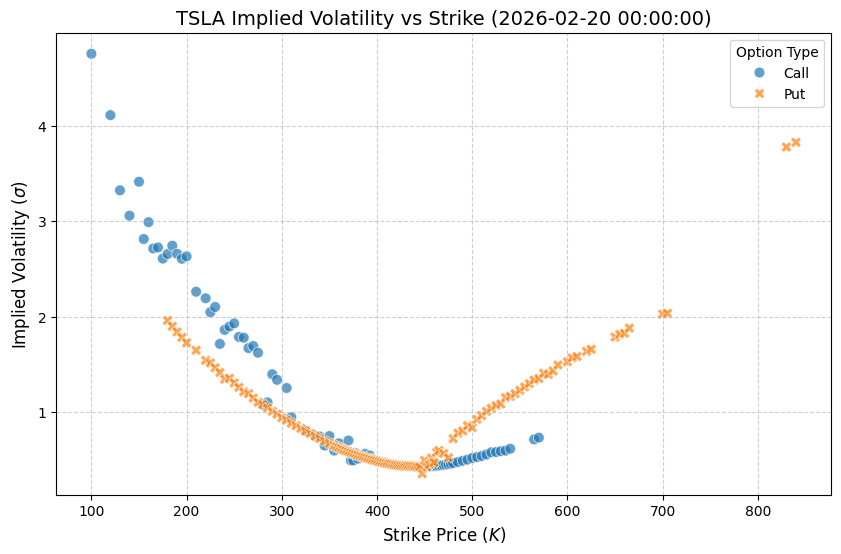

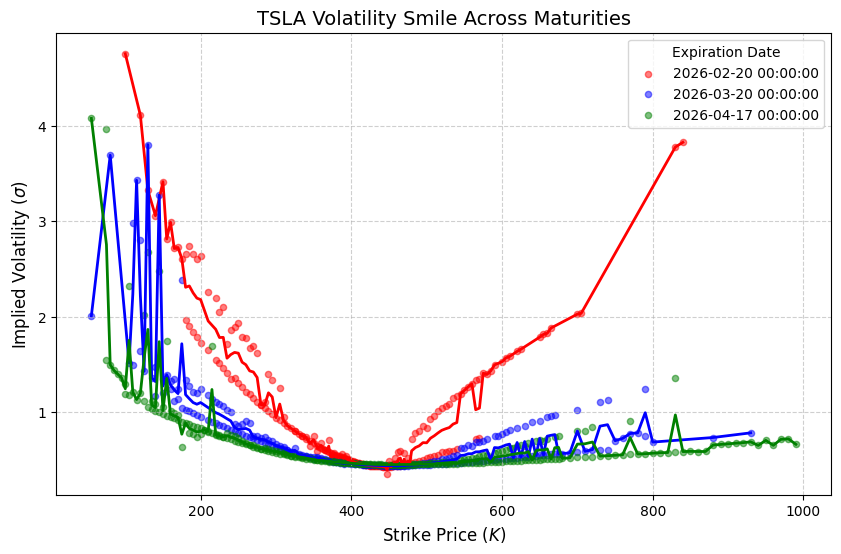

In [12]:

target_symbol = 'TSLA' 
plot_data = df_calc[(df_calc['Underlying_Symbol'] == target_symbol) & 
                    (df_calc['Calculated_IV'].notna())].copy()
expirations = sorted(plot_data['Expiration'].unique())


# Plot 1: IV vs Strike 
# Feb 20
closest_exp = expirations[0]
subset_closest = plot_data[plot_data['Expiration'] == closest_exp]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_closest, x='strike', y='Calculated_IV', 
                hue='Type', style='Type', s=60, alpha=0.7)

plt.title(f'{target_symbol} Implied Volatility vs Strike ({closest_exp})', fontsize=14)
plt.xlabel('Strike Price ($K$)', fontsize=12)
plt.ylabel('Implied Volatility ($\sigma$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Option Type')
plt.show()

# Plot 2: IV vs Strike (three expiry date)

plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
markers = ['o', 's', '^']

for i, exp in enumerate(expirations):
    subset = plot_data[plot_data['Expiration'] == exp]
    subset = subset.sort_values('strike')
    plt.scatter(subset['strike'], subset['Calculated_IV'], 
                color=colors[i], label=f'{exp}', alpha=0.5, s=20)
    avg_iv_by_strike = subset.groupby('strike')['Calculated_IV'].mean()
    plt.plot(avg_iv_by_strike.index, avg_iv_by_strike.values, 
             color=colors[i], linestyle='-', linewidth=2)

plt.title(f'{target_symbol} Volatility Smile Across Maturities', fontsize=14)
plt.xlabel('Strike Price ($K$)', fontsize=12)
plt.ylabel('Implied Volatility ($\sigma$)', fontsize=12)
plt.legend(title='Expiration Date')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

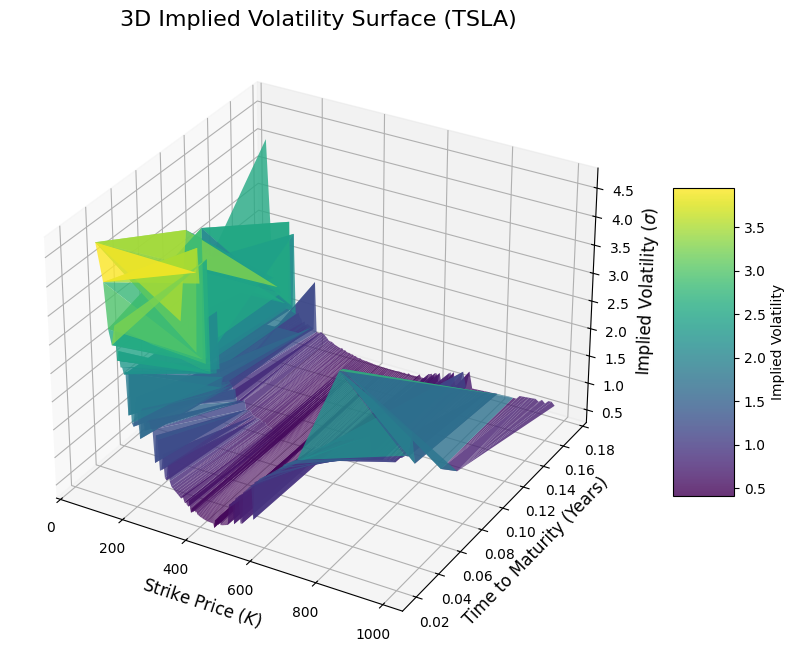

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Bonus: 3D Plot of Volatility Surface

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
data_3d = plot_data.dropna(subset=['Calculated_IV', 'Time_to_Maturity', 'strike'])

X = data_3d['strike']
Y = data_3d['Time_to_Maturity']
Z = data_3d['Calculated_IV']

surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
# label
ax.set_title(f'3D Implied Volatility Surface ({target_symbol})', fontsize=16)
ax.set_xlabel('Strike Price ($K$)', fontsize=12)
ax.set_ylabel('Time to Maturity (Years)', fontsize=12)
ax.set_zlabel('Implied Volatility ($\sigma$)', fontsize=12)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Implied Volatility')
ax.view_init(elev=30, azim=-60)
plt.show()

In [14]:
import numpy as np
from scipy.stats import norm
import pandas as pd

def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0: return max(0, S - K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Greeks
def Greeks_Exact(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    vega = S * np.sqrt(T) * norm.pdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return delta, vega, gamma

# Numerical Greeks
def Greeks_Approx(S, K, T, r, sigma):
    # Small step
    dS = 0.01 
    dSigma = 0.001
    # Delta & Gamma Approx
    p_up = bs_call_price(S + dS, K, T, r, sigma)
    p_down = bs_call_price(S - dS, K, T, r, sigma)
    p_curr = bs_call_price(S, K, T, r, sigma)
    delta_app = (p_up - p_down) / (2 * dS)
    gamma_app = (p_up - 2 * p_curr + p_down) / (dS**2)

    # Vega Approx
    v_up = bs_call_price(S, K, T, r, sigma + dSigma)
    v_down = bs_call_price(S, K, T, r, sigma - dSigma)
    vega_app = (v_up - v_down) / (2 * dSigma)
    
    return delta_app, vega_app, gamma_app

test_df = df_calc[(df_calc['Underlying_Symbol'] == 'TSLA') & 
                  (df_calc['Type'] == 'Call') & 
                  (df_calc['Calculated_IV'].notna())].head(5).copy()

results = []

for _, row in test_df.iterrows():
    S, K, T, r, sigma = row['Underlying_Price_Snapshot'], row['strike'], \
                        row['Time_to_Maturity'], row['Risk_Free_Rate'], \
                        row['Calculated_IV']
    
    d_ex, v_ex, g_ex = Greeks_Exact(S, K, T, r, sigma)
    d_ap, v_ap, g_ap = Greeks_Approx(S, K, T, r, sigma)
    
    results.append({
        'Strike': K,
        'Delta_Ex': d_ex, 'Delta_App': d_ap, 'Diff_D': abs(d_ex - d_ap),
        'Vega_Ex': v_ex, 'Vega_App': v_ap, 'Diff_V': abs(v_ex - v_ap),
        'Gamma_Ex': g_ex, 'Gamma_App': g_ap, 'Diff_G': abs(g_ex - g_ap)
    })

greeks_table = pd.DataFrame(results)
print("Greeks Comparison Table")
print(greeks_table.round(6))

Greeks Comparison Table
   Strike  Delta_Ex  Delta_App  Diff_D   Vega_Ex  Vega_App  Diff_V  Gamma_Ex  \
0   100.0  0.993773   0.993773     0.0  1.014870  1.014870     0.0  0.000064   
1   120.0  0.993316   0.993316     0.0  1.080548  1.080548     0.0  0.000079   
2   130.0  0.997143   0.997143     0.0  0.505755  0.505755     0.0  0.000046   
3   140.0  0.997368   0.997368     0.0  0.469520  0.469520     0.0  0.000046   
4   150.0  0.991815   0.991815     0.0  1.291708  1.291708     0.0  0.000113   

   Gamma_App  Diff_G  
0   0.000064     0.0  
1   0.000079     0.0  
2   0.000046     0.0  
3   0.000046     0.0  
4   0.000113     0.0  


In [15]:
def bs_price(S, K, T, r, sigma, option_type='Call'):
    if T <= 0 or sigma <= 0: return max(0, S - K) if option_type == 'Call' else max(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'Call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
df2 = pd.read_csv('DATA2_option.csv')
equity2 = pd.read_csv('DATA2_equity.csv')

df2['Market_Price_Actual'] = (df2['bid'] + df2['ask']) / 2
df2['Expiration'] = pd.to_datetime(df2['Expiration'])
data2_download_date = pd.to_datetime('2026-02-13') 
df2['Download_Date'] = data2_download_date

r2 = 0.0364 
df2['Risk_Free_Rate'] = r2
for symbol in equity2['Symbol'].unique():
    s2 = equity2[equity2['Symbol'] == symbol]['Price'].iloc[0]
    df2.loc[df2['Underlying_Symbol'] == symbol, 'S_Data2'] = s2

# Expiry date
df2['T_Data2'] = (df2['Expiration'] - df2['Download_Date']).dt.days / 365

# DATA1 IV
iv_from_data1 = df_calc[['Underlying_Symbol', 'Expiration', 'Type', 'strike', 'Calculated_IV']].copy()
iv_from_data1['Expiration'] = pd.to_datetime(iv_from_data1['Expiration'])
df_merged = pd.merge(df2, iv_from_data1, 
                     on=['Underlying_Symbol', 'Expiration', 'Type', 'strike'], 
                     how='inner')
def calculate_p12_price(row):
    return bs_price(
        S=row['S_Data2'],
        K=row['strike'],
        T=row['T_Data2'],
        r=row['Risk_Free_Rate'],
        sigma=row['Calculated_IV'],
        option_type=row['Type']
    )
df_merged['BS_Price_Theory'] = df_merged.apply(calculate_p12_price, axis=1)
df_merged['Price_Error'] = df_merged['BS_Price_Theory'] - df_merged['Market_Price_Actual']

cols_show = ['Underlying_Symbol', 'Expiration', 'Type', 'strike', 
             'Calculated_IV', 'Market_Price_Actual', 'BS_Price_Theory', 'Price_Error']

print("Predicting DATA2 Prices using DATA1 IV")
print(df_merged[cols_show].head(10))
mean_error = df_merged['Price_Error'].abs().mean()
print(f"\n MAE: ${mean_error:.4f}")

Predicting DATA2 Prices using DATA1 IV
  Underlying_Symbol Expiration  Type  strike  Calculated_IV  \
0              TSLA 2026-02-20  Call   100.0       4.754973   
1              TSLA 2026-02-20  Call   110.0            NaN   
2              TSLA 2026-02-20  Call   120.0       4.111580   
3              TSLA 2026-02-20  Call   130.0       3.324528   
4              TSLA 2026-02-20  Call   140.0       3.058768   
5              TSLA 2026-02-20  Call   150.0       3.414462   
6              TSLA 2026-02-20  Call   155.0       2.814554   
7              TSLA 2026-02-20  Call   160.0       2.990751   
8              TSLA 2026-02-20  Call   165.0       2.715063   
9              TSLA 2026-02-20  Call   170.0       2.725477   

   Market_Price_Actual  BS_Price_Theory  Price_Error  
0              319.950       318.192693    -1.757307  
1              327.000              NaN          NaN  
2              300.225       298.142526    -2.082474  
3              290.175       287.718939    -2.4